In [ ]:
# !pip install opencv-python
# !apt update && apt install -y libsm6 libxext6
# !apt-get install -y libxrender-dev
# !pip install scikit-image
# !pip install keras
# !pip install tensorflow
# !pip install scikit-learn
# !pip install pandas

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
#@title Importing Libraries
import time
import os
import cv2
import numpy as np
from skimage import transform as tf
import random
import glob
import tensorflow
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
DIR = "/content/drive/My Drive/ColabNotebooks/TM imagesCNN/"

In [ ]:
diseases = os.listdir(DIR)
print(diseases)

In [ ]:
for disease in diseases:
        # get a list of subdirectories that start with this character
        directory_list = (glob.glob("{}/*".format(DIR, disease)))
print(directory_list)

In [ ]:
#@title Dataset Stats
def dataset_stats():
    
    # This is an array with the all the diseases available in the directory.

    diseases = os.listdir(DIR)
    
    # dictionary where we will store the stats
    stats = []
    
    for disease in diseases:
        # get a list of subdirectories that start with this character
        directory_list = sorted(glob.glob("{}/*".format(DIR, disease)))
        
    for sub_directory in directory_list:
        file_names = [file for file in os.listdir(sub_directory)]
        file_count = len(file_names)
        sub_directory_name = os.path.basename(sub_directory)
        stats.append({ "Code": sub_directory_name[:sub_directory_name.find('-')],
                        "Image count": file_count, 
                       "Folder name": os.path.basename(sub_directory),
                        "File names": file_names})

    
    df = pd.DataFrame(stats)
    
    return df

In [ ]:
import imgaug.augmenters as iaa
class re_data:
    def read_path():
        l=[]
        for name in glob.glob('./images/*.jpg'):
            l.append(name)
        return l
            
    def Read_data(data,l):
        images =[]
        path='./images/'
        for img in data:
            path=path+img
            if path in l:
                im=imread(path)
                images.append(im)
            path='./images/'
        return np.array(images)
    
    def plot_image(images, captions=None, cmap=None ):
        f, axes = plt.subplots(1, len(images), sharey=True)
        f.set_figwidth(15)
        for ax,image in zip(axes, images):
            ax.imshow(image, cmap)
            
    def flip_image(image):
        return np.fliplr(image)
    
    def shear_image(image):
        shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
        matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])
        shear_transforms = tf.AffineTransform(shear=np.deg2rad(45))
        shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
        shear_image = tf.warp(image, shear_matrix)
        return shear_image
        
    def Gray_image(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray=tf.resize(gray,(224,224,3),anti_aliasing=False)
        gaussian = cv2.GaussianBlur(gray,(3,3),0)
        return gaussian
        
    def rotate_45(image):
        # rotation
        shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
        matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])
        rot_transforms =  tf.AffineTransform(rotation=np.deg2rad(45))
        rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
        rot_image = tf.warp(image, rot_matrix)
        return rot_image
        
    def Zoom_out(image):
        # scaling 
        shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
        matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])
        scale_transforms = tf.AffineTransform(scale=(2, 2))
        scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
        scale_image_zoom_out = tf.warp(image, scale_matrix)
        return scale_image_zoom_out
        
    
    def Zoom_in(image):
        shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
        matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])
        scale_transforms = tf.AffineTransform(scale=(0.5, 0.5))
        scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
        scale_image_zoom_in = tf.warp(image, scale_matrix)
        return scale_image_zoom_in
        
    def Translation(image):
        # translation
        transaltion_transforms = tf.AffineTransform(translation=(50, 50))
        translated_image = tf.warp(image, transaltion_transforms)
        return translated_image
        
    def Contrast(image):
        contrast=iaa.GammaContrast(gamma=2.0)
        contrast_image =contrast.augment_image(image)
        return contrast_image

In [ ]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]
type(dataset)

In [ ]:
dataset

In [ ]:
#@title Load Images
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)
            
            # #Removing black regions
            # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # mask = gray>100
            # image = image[np.ix_(mask.any(1),mask.any(0))]

            # Resize it to 224 x 224
            # image = cv2.resize(image, (224,224))

            #Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)
            
            #Now save images
            # cv2.imwrite(file_path,image)

    return images, labels

In [ ]:
def Load_Images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)

    return np.array(images)

In [ ]:
pathfolder = DIR+"Glue ear/"
df= Load_Images_from_folder(pathfolder)
# df= np.array([df])
df.shape

In [ ]:
from matplotlib.image import imsave
X_aug=[]
y_aug=[]
name='aug'
path = '/content/drive/My Drive/ColabNotebooks/Aug_Images/GlueEar/'
for i in range(len(df)):
        img=df[i]
        X_aug.append(img)
        imsave(path+name+str(i)+'.jpg', img)
        
        img_flip = re_data.flip_image(df[i])
        X_aug.append(img_flip)
        imsave(path+name+'_flip'+str(i)+'.jpg', img_flip)

        img_shear=re_data.shear_image(df[i])
        X_aug.append(img_shear)
        imsave(path+name+'_shear'+str(i)+'.jpg', img_shear)
    
        gray=re_data.Gray_image(df[i])
        X_aug.append(gray)
        imsave(path+name+'_gray'+str(i)+'.jpg', gray)
    
        gray_flip=re_data.Gray_image(img_flip)
        X_aug.append(gray_flip)
        imsave(path+name+'_gray_flip'+str(i)+'.jpg', gray_flip)
    
        img_rotate=re_data.rotate_45(df[i])
        X_aug.append(img_rotate)
        imsave(path + name +'_rotate'+str(i)+'.jpg', img_rotate)
    
        img_zoom_out=re_data.Zoom_out(df[i])
        X_aug.append(img_zoom_out)
        imsave(path + name +'_out'+str(i)+'.jpg', img_zoom_out)
    
        img_zoom_in=re_data.Zoom_in(df[i])
        X_aug.append(img_zoom_in)
        imsave(path + name +'_in'+str(i)+'.jpg', img_zoom_in)
    
        img_translation=re_data.Translation(df[i])
        X_aug.append(img_translation)
        imsave(path + name + '_translation'+str(i)+'.jpg', img_translation)
    
        img_Contrast=re_data.Contrast(df[i])
        X_aug.append(img_Contrast)
        imsave(path + name + '_Contrast'+str(i)+'.jpg', img_Contrast)

In [ ]:
DIR = "/content/drive/My Drive/ColabNotebooks/Aug_Images/"

In [ ]:
diseases = os.listdir(DIR)
print(diseases)
for disease in diseases:
        # get a list of subdirectories that start with this character
        directory_list = (glob.glob("{}/*".format(DIR, disease)))
print(directory_list)

In [ ]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]
type(dataset)
dataset

## Loading Images through Image Data Generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()
...
# load and iterate training dataset
train_it = datagen.flow_from_directory('./Aug_Images/Aug_Images/', class_mode='categorical',target_size=(224,224),shuffle=True)
# load and iterate validation dataset
val_it = datagen.flow_from_directory('./TMimagesCNN/TM imagesCNN', class_mode='categorical',target_size=(224,224),shuffle=True)
# load and iterate test dataset
test_it = datagen.flow_from_directory('./test', class_mode='categorical',target_size=(224,224),shuffle=True)

## Loading model

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import ResNet50


In [53]:
# create the base pre-trained model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='softmax')(x)
# and a logistic layer -- we have 6 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

img_width, img_height = 224, 224




In [54]:
# train the model on the new data for a few epochs
historyA = model.fit_generator(train_it, epochs=15,
                    initial_epoch=0, validation_data=val_it)

Epoch 1/15
33/33 [==============================] - 24s 715ms/step - loss: 1.7706 - accuracy: 0.2128 - val_loss: 1.8385 - val_accuracy: 0.1092
Epoch 2/15
33/33 [==============================] - 23s 684ms/step - loss: 1.7077 - accuracy: 0.3559 - val_loss: 1.8530 - val_accuracy: 0.1092
Epoch 3/15
33/33 [==============================] - 23s 683ms/step - loss: 1.6787 - accuracy: 0.3826 - val_loss: 1.8684 - val_accuracy: 0.1092
Epoch 4/15
33/33 [==============================] - 23s 682ms/step - loss: 1.6366 - accuracy: 0.4475 - val_loss: 1.8334 - val_accuracy: 0.2353
Epoch 5/15
33/33 [==============================] - 23s 710ms/step - loss: 1.6207 - accuracy: 0.4408 - val_loss: 1.7489 - val_accuracy: 0.3782
Epoch 6/15
33/33 [==============================] - 23s 692ms/step - loss: 1.6032 - accuracy: 0.4437 - val_loss: 1.7352 - val_accuracy: 0.3782
Epoch 7/15
33/33 [==============================] - 22s 680ms/step - loss: 1.5932 - accuracy: 0.4351 - val_loss: 1.8875 - val_accuracy: 0.1597

In [55]:
accA = model.evaluate_generator(val_it, steps=1,  max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
accA

1/1 [==============================] - 0s 387ms/step - loss: 1.7354 - accuracy: 0.3750


[1.7353849411010742, 0.375]

In [ ]:
 # Predicting the Test set results
y_pred = model.predict(X_test)
y_pred_a = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), y_pred_a.argmax(axis=1))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


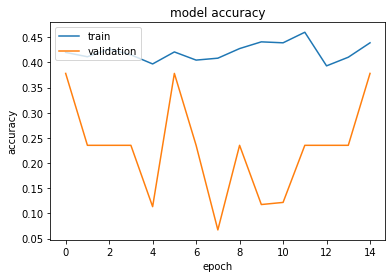

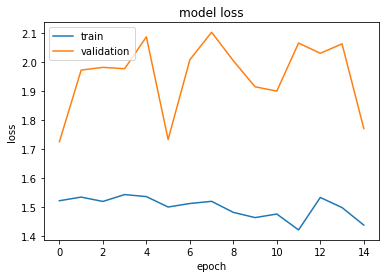

In [46]:
print(historyA.history.keys())
#  "Accuracy"
plt.plot(historyA.history['accuracy'])
plt.plot(historyA.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(historyA.history['loss'])
plt.plot(historyA.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [62]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:700]:
   layer.trainable = False
for layer in model.layers[700:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
historyB = model.fit_generator(train_it, epochs=2,
                    initial_epoch=0, validation_data=val_it)

Epoch 1/2
33/33 [==============================] - 24s 722ms/step - loss: 1.7238 - accuracy: 0.2844 - val_loss: 2.0583 - val_accuracy: 0.1092
Epoch 2/2
33/33 [==============================] - 24s 734ms/step - loss: 1.8080 - accuracy: 0.2080 - val_loss: 1.7557 - val_accuracy: 0.3782


In [68]:
# this is a generator for test data
# test_generator = test_datagen.flow(X_test, y_test)

# let's test our model
accB = model.evaluate_generator(val_it, steps=1,  max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)

1/1 [==============================] - 0s 398ms/step - loss: 1.7508 - accuracy: 0.4375


In [69]:
accB

[1.750840187072754, 0.4375]

In [ ]:
 # Predicting the Test set results
y_pred = model.predict(X_test)
y_pred_a = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.argmax(axis=1), y_pred_a.argmax(axis=1))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


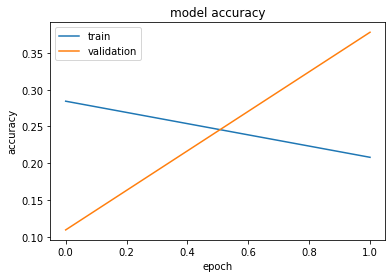

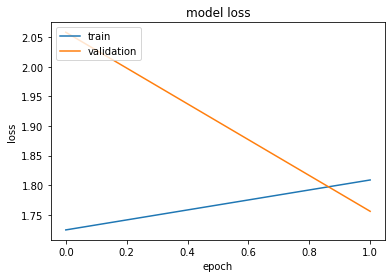

In [66]:
print(historyB.history.keys())
#  "Accuracy"
plt.plot(historyB.history['accuracy'])
plt.plot(historyB.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()